In [58]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
import os
import numpy as np
import cv2 as cv
import torch
from google.colab.patches import cv2_imshow


In [28]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [31]:
latent_dim = 32

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(724, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 64, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 128)  73856       ['conv2d_9[0][0]']         

In [32]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(724, activation="relu")(latent_inputs)
x = layers.Dense(16384, activation="relu")(x)
x = layers.Reshape((8, 8, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_7 (Dense)             (None, 724)               23892     
                                                                 
 dense_8 (Dense)             (None, 16384)             11878400  
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 16, 16, 256)      590080    
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 32, 32, 128)      295040    
 Transpose)                                                

In [33]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [34]:
dir_path = "/content/gdrive/MyDrive/mosip_project/data/IITD_LQ_128"

In [35]:
shape = (128, 128, 1)
images = []
for i in os.listdir(dir_path):
  image_path = os.path.join(dir_path, i)
  image = cv.imread(image_path)
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  # image = image[:, :, np.newaxis]
  # print(type(image), np.shape(image))
  images.append(image)
images=np.array(images)

In [36]:
np.shape(images)

(964, 128, 128)

In [37]:
images = np.expand_dims(images, -1).astype("float32") / 255

In [40]:
# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# mnist_digits = np.concatenate([x_train, x_test], axis=0)
# images = np.expand_dims(images, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(images, epochs=300, batch_size=128)

Epoch 1/300
8/8 [==============================] - 7s 165ms/step - loss: 10164.9405 - reconstruction_loss: 10038.9551 - kl_loss: 42.7348
Epoch 2/300
8/8 [==============================] - 1s 152ms/step - loss: 9803.4313 - reconstruction_loss: 9728.7676 - kl_loss: 36.2947
Epoch 3/300
8/8 [==============================] - 1s 153ms/step - loss: 9694.7220 - reconstruction_loss: 9654.1553 - kl_loss: 41.6895
Epoch 4/300
8/8 [==============================] - 1s 153ms/step - loss: 9641.5915 - reconstruction_loss: 9595.6367 - kl_loss: 44.5978
Epoch 5/300
8/8 [==============================] - 1s 154ms/step - loss: 9594.4878 - reconstruction_loss: 9560.7295 - kl_loss: 44.4706
Epoch 6/300
8/8 [==============================] - 1s 153ms/step - loss: 9558.0204 - reconstruction_loss: 9525.9912 - kl_loss: 44.7328
Epoch 7/300
8/8 [==============================] - 1s 153ms/step - loss: 9567.0486 - reconstruction_loss: 9504.7803 - kl_loss: 44.2756
Epoch 8/300
8/8 [==============================] - 1s

[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0]
1/1 [==============================] - 0s 27ms/step
[-0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0, -0.6, 1.0]
1/1 [==============================] - 0s 27ms/step
[-0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0, -0.19999999999999996, 1.0]
1/1 [==============================] - 0s 25ms/step
[0.20000000000000018, 1.0, 0.20000000000000018, 1.0, 0.20

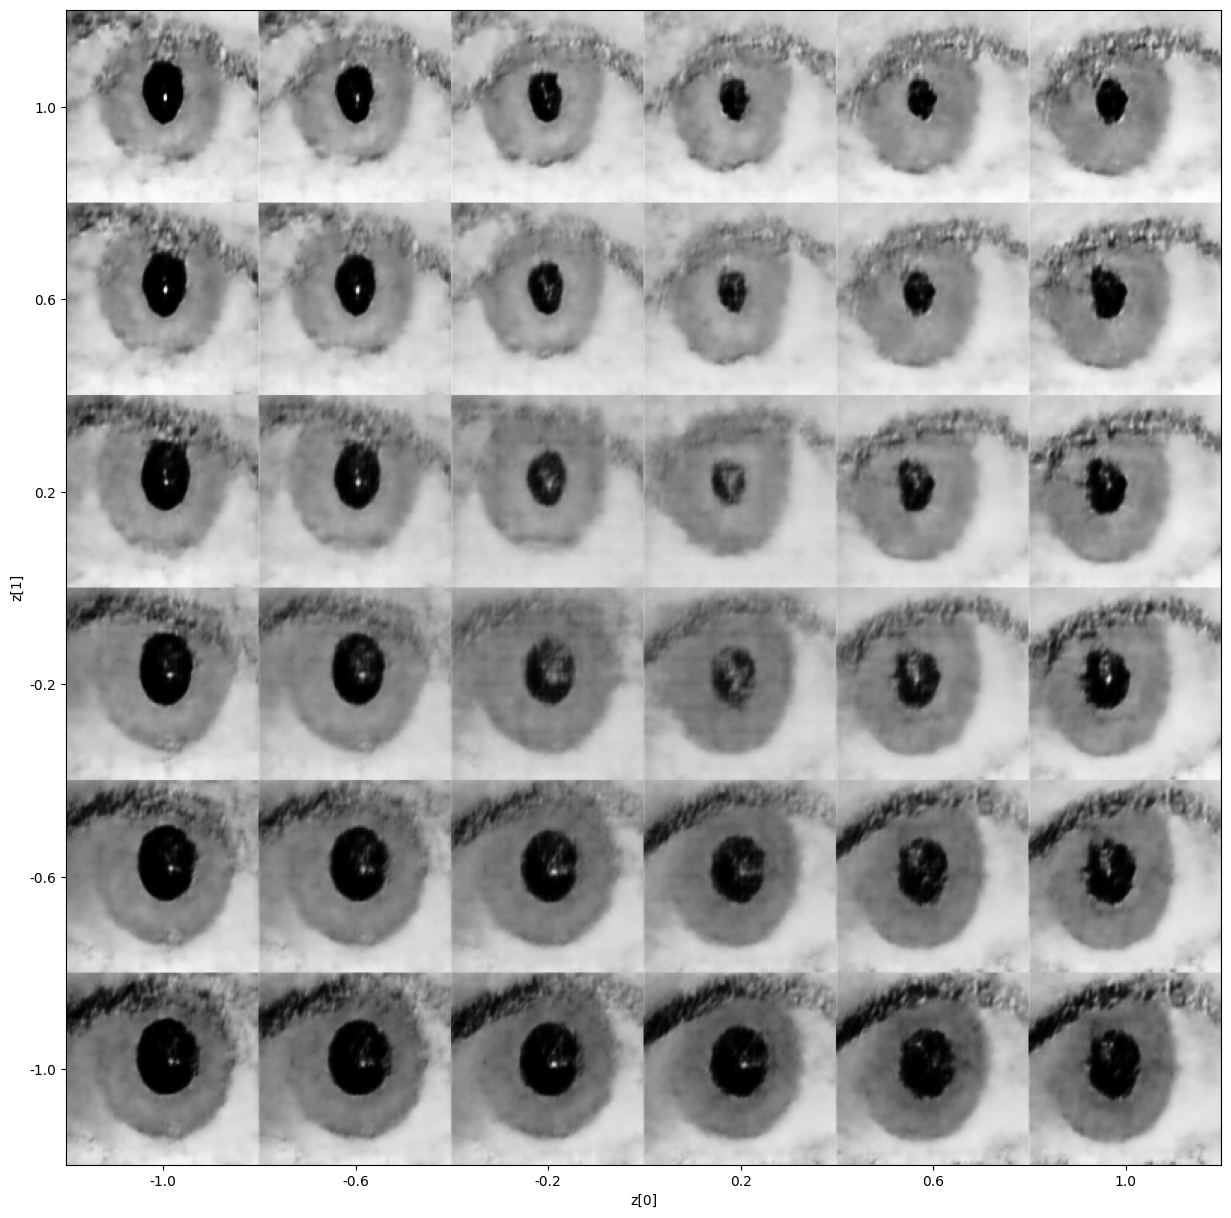

In [65]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=6, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            temp=[]
            for _ in range(16):
                temp.append(xi)
                temp.append(yi)
            print(temp)
            z_sample = np.array([temp])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

In [75]:
digit_size = 128
num_samples = 100
images=[]

for _ in range(num_samples):
    temp=((np.random.rand(latent_dim)*2)-1).tolist()
    z_sample=np.array([temp])
    x_decoded = (vae.decoder.predict(z_sample))*255
    images.append(x_decoded[0].reshape(digit_size, digit_size))



# for i, yi in enumerate(grid_y):
#     for j, xi in enumerate(grid_x):
#         temp=[]
#         for _ in range(16):
#           temp.append(xi)
#           temp.append(yi)
#         z_sample = np.array([temp])
#         x_decoded = vae.decoder.predict(z_sample)
#         digit = x_decoded[0].reshape(digit_size, digit_size)

1/1 [==============================] - 0s 26ms/step


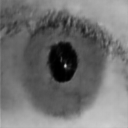

In [76]:
cv2_imshow(images[0])

In [79]:
save_dir = "/content/gdrive/MyDrive/mosip_project/data/generated_images"
for i in range(len(images)):
  path = os.path.join(save_dir, str(i))
  path += ".png"
  cv.imwrite(path, images[i])
